In [0]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
print ('-This section done-')

import sys
sys.path.append("/Users/omerorhan/Desktop/UCSC/Deep Learning/DeepLearningUCSC/venv/homework/Assignments/") 


-This section done-


In [0]:
#getting data
import weather
weather.maybe_download_and_extract()
cities = weather.cities
print(cities)
#%%time
df = weather.load_resampled_data()
print(df.head())

- Download progress: 100.0%
Download finished. Extracting files.
Done.
['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']
                      Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.

-This section done-


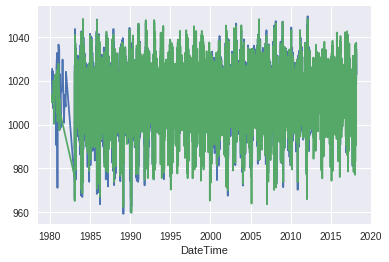

In [0]:
df['Esbjerg']['Pressure'].plot()
df['Roskilde']['Pressure'].plot()
df.values.shape
df.head(1)

df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print ('-This section done-')

In [0]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [0]:
# Converting Data Frames to Numpy array::::
x_data = df
print("X_Shape::::")
print(type(x_data))
print("Shape:", x_data.shape)

num_data = len(x_data)
print("# of input data ",num_data)
train_split = 1
num_train = int(train_split * num_data)
print("# of Training data: ",num_train)
x_train = x_data[0:num_train]
num_x_signals = x_data.shape[1]
print(num_x_signals)

X_Shape::::
<class 'pandas.core.frame.DataFrame'>
Shape: (333109, 20)
# of input data  333109
# of Training data:  333109
20


In [0]:
# Scaling data
#The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use scikit-learn for this.
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
#Data Generator
print(x_train_scaled.shape)


Min: 0.0
Max: 1.0000000000000002
(333109, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
lookback = 2352 # was 1440. 24 hours per day into 14 days = 168*14 = 2352
step = 6 # Original was 6
delay = 144 # We will predict 1 days in future. hence 24*6 = 144
batch_size = 128
#data—The original array of floating-point data
#lookback—How many timesteps back the input data should go.
#delay—How many timesteps in the future the target should be.
#min_index and max_index—Indices in the data array that delimit which time-
#steps to draw from. This is useful for keeping a segment of the data for valida-
#tion and another for testing.
#shuffle—Whether to shuffle the samples or draw them in chronological order.
#batch_size—The number of samples per batch.
#step—The period, in timesteps, at which you sample data. set it to 1 in
#order to draw one data point every hour.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=1, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1])) # Size = Batchsize,lookback,20
        targets = np.zeros((len(rows),)) #Size typically Batchsize
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        #print(np.shape(samples))
        #print(np.shape(targets))
        yield samples, targets

        
train_gen = generator(x_train_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=20000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x_train_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=20001,
                    max_index=30000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(x_train_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=30001,
                    max_index=40000,
                    step=step,
                    batch_size=1)
val_steps = (30000 - 20001 - lookback)



In [0]:
#First model with GRU
dropout = 0.2
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,
                             recurrent_dropout=0.2, input_shape=(None, x_train_scaled.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)


In [0]:

import keras
keras.models.save_model(model,"model_GRU.h5")
model = keras.models.load_model("model_GRU.h5")  # Load Keras model we learned using KerasPractice notebook
#prediction = model.predict(test_gen)  # Run the actual classification

for i,j in test_gen:
  print(i.shape)
  #print(j.shape)
  
  prediction = model.predict(i)
  print(i[0,0,:])
  print(prediction)
  print(j[0])
  break

In [0]:

#Second model with LSTM
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(16,dropout=0,
                             recurrent_dropout=0, input_shape=(None, x_train_scaled.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)



In [0]:
#Third model with Conventional NN

import keras
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
early_stop = EarlyStopping(patience = 2, mode ='max')
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x_train_scaled.shape[-1])))
model.add(Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps, callbacks = [early_stop])
keras.models.save_model(model,"model.h5")

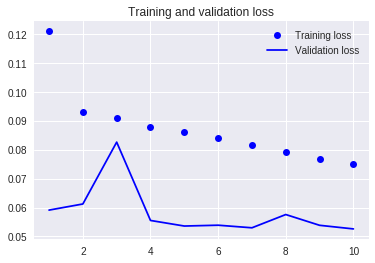

In [0]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
